# Evolution strategies on test functions for optimization

## Test functions for optimization

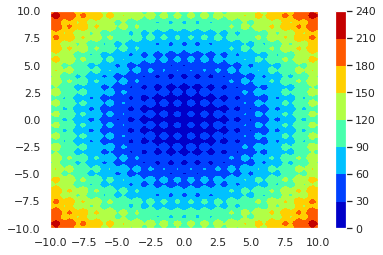

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import cma


x = np.linspace(-10, 10, num=100)
y = np.linspace(-10, 10, num=100)
x, y = np.meshgrid(x, y)

f = cma.ff.rastrigin
z = np.reshape(f(np.stack([x, y], -1).reshape(-1, 2)), [100, 100])

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
c = ax.contourf(x, y, z, cmap='jet')
fig.colorbar(c)

(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 100 (seed=1, Wed Jan 22 17:58:42 2020)
Generation # 1: 8923.084084029262
Generation # 100: 1173.3294879949835
Generation # 200: 970.7187789547896
Generation # 300: 899.2954501845373
Generation # 400: 899.2954501845373
Generation # 500: 751.9006463836787
Generation # 600: 205.48003166879062
Generation # 700: 198.03484740992917
Generation # 800: 197.99667973127623
Generation # 900: 197.99649043726072
Generation # 1000: 197.99648923751568

Total time: 0:08:17
Generation # 1: 8953.041771621152
Generation # 100: 1398.93540477424
Generation # 200: 1285.7285723922569
Generation # 300: 1255.6005656964403
Generation # 400: 1101.1564215135456
Generation # 500: 909.4570841510273
Generation # 600: 300.9056723208579
Generation # 700: 291.16309842724263
Generation # 800: 305.6610662848776
Generation # 900: 306.5457105776302
Generation # 1000: 301.69629808813806

Total time: 0:00:16


Text(0.5, 1.0, 'Rastrigin function - 100 dim')

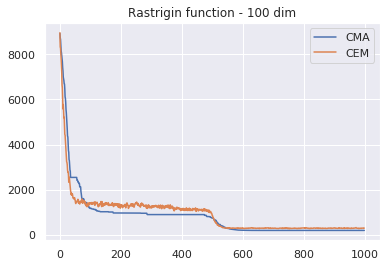

In [5]:
import time
from datetime import timedelta
from concurrent.futures import ProcessPoolExecutor

import lagom
import lagom.utils as utils

from cma.fitness_transformations import Expensify


cem = lagom.CEM([9.0]*100, 1.0, {'popsize': 32, 'seed': 1, 'elite_ratio': 0.25, 'noise_scheduler_args': [1.0, 0.001, 500, 0]})
cma = lagom.CMAES([9.0]*100, 1.0, {'popsize': 32, 'seed': 1})
for name, es in [('CMA', cma), ('CEM', cem)]:
    t0 = time.perf_counter()
    with ProcessPoolExecutor(max_workers=80) as executor:
        logger = lagom.Logger()
        #g = Expensify(f, time=0.01)
        g = f
        g = utils.CloudpickleWrapper(g)  # extremely useful for parallel, avoid getting stuck sometimes

        for generation in range(1000):
            solutions = es.ask()
            function_values = list(executor.map(g, solutions, chunksize=16))
            es.tell(solutions, function_values)
            if generation == 0 or (generation+1)%100 == 0:
                print(f'Generation # {generation+1}: {es.result.fbest}')
            logger('generation', generation)
            logger('fbest', es.result.fbest)

    print(f'\nTotal time: {timedelta(seconds=round(time.perf_counter() - t0))}')
    ax = sns.lineplot(logger.logs['generation'], logger.logs['fbest'], label=name)
    
ax.set_title('Rastrigin function - 100 dim')